In [228]:
class User:
    def __init__(self, name, label="none"): 
        self.id = name
        self.label = label
        self.advisors = [] #neighbors
        self.providers = []
        self.interactions = {}
        self.total_interactions = 0
        self.provider_raputation = {}
        self.advisor_reputation = {}
        self.decay = 1 #longitivity
        self.phi = 0.5 #w
        self.epsilon = 1 #uncertainity
        self.limit = 0 #tolarance limit
#         self.alpha = 0.8 #consumer confidence
        self.satisfaction = {}
        self.disatisfaction = {}
        self.b_satisfaction = {}
        self.b_disatisfaction = {}

        
    def reset(self):
        self.advisors = [] #neighbors
        self.providers = []
        self.interactions = {}
        self.total_interactions = 0
        self.provider_raputation = {}
        self.advisor_reputation = {}
        self.satisfaction = {}
        self.disatisfaction = {}
        self.b_satisfaction = {}
        self.b_disatisfaction = {}
        
            
    def interact(self, provider, rating):
        if provider.id != self.id:
            if provider in self.providers:
                ratelist = self.interactions[provider]
            else:
                ratelist = []
                self.providers.append(provider)

            ratelist.append(rating)
            self.interactions[provider] = ratelist
            self.total_interactions += 1

            self.eval_provider(provider, rating)
            self.eval_provider(provider, rating, bayes = True)
        else:
            print('I cant interact with myself')
        
        
    def eval_provider(self, provider, rating, bayes = False):
        exp_val_n = len(self.interactions[provider])

        rj = (1- rating) * self.phi #disatisfaction self.phi = w, rj = ds
        sj = (1+ rating) * self.phi #satisfaction self.phi = w  sj = sj
        
        if bayes:
            if provider in self.b_satisfaction:
                cumilative_satisfaction = self.b_satisfaction[provider]
                cumilative_disatisfaction = self.b_disatisfaction[provider]
                cumilative_satisfaction += sj
                cumilative_disatisfaction += rj
            else:
                cumilative_satisfaction = sj
                cumilative_disatisfaction = rj
            self.b_satisfaction[provider] = cumilative_satisfaction
            self.b_disatisfaction[provider] = cumilative_disatisfaction
        else:
            decay_factor = self.decay **(exp_val_n - self.limit)
            rj *= decay_factor
            sj *= decay_factor
            self.limit += 1
            if provider in self.satisfaction:
                cumilative_satisfaction = self.satisfaction[provider]
                cumilative_disatisfaction = self.disatisfaction[provider]
                cumilative_satisfaction += sj
                cumilative_disatisfaction +=rj
            else:
                cumilative_satisfaction = sj
                cumilative_disatisfaction = rj
            self.satisfaction[provider] = cumilative_satisfaction
            self.disatisfaction[provider] = cumilative_disatisfaction
        
        self.get_belief(provider)
    
    def get_belief(self, provider):
        belief = 0 
        disbelief = 0 
        uncertainity = 0
        if provider in self.satisfaction:
            cum_sat = self.satisfaction[provider]
            cum_dis = self.disatisfaction[provider]
            total_sat_dit = cum_dis+cum_sat
            den = total_sat_dit + self.epsilon 
            belief = cum_sat /(den)
            disbelief = cum_dis /(den)
            uncertainity = self.epsilon / (den)    
        return belief, disbelief, uncertainity
        
        
    def provider_raputation(self, provider):
        return provider_raputation[provider]
    
    def get_providers(self):
        return self.providers
        

    def get_similarity(self, advisor):

        common_providers = [x for x in advisor.get_providers() if x in self.get_providers()]
        similarity = -100 #note this is just for checking if the advisor has a common vendor
        
        if len(common_providers) > 0:
            cum_dist = 0
            for p in common_providers:
                    
                    a_bel, a_disbel, a_unc = self.get_belief(p)
                    b_bel, b_disbel, b_unc = advisor.get_belief(p)
                    nonsqrt= self.get_distance(advisor, p)
                    dist = nonsqrt** (1/2)
                    dist = dist/(2**(1/2))
                    cum_dist += dist
            meanormilsed_distance = cum_dist/len(common_providers)
            similarity = 1 - meanormilsed_distance
        return similarity
    
    def get_distance(self, advisor, p):
        a_bel, a_disbel, a_unc = self.get_belief(p)
        b_bel, b_disbel, b_unc = advisor.get_belief(p)
        nonsqrt=((a_bel - b_bel)**2) + ((a_disbel - b_disbel)**2) + ((a_unc - b_unc)**2)
        return nonsqrt
            
    def get_global_crediblity(self):
        cum_bel = 0
#         print('cum_bel'+str(cum_bel))
#         print('self.providers'+str(self.providers))
        p_count = 0
        gp = 0
        for p in self.providers:
            b ,_ , _ = p.get_belief(self)
            cum_bel += b
            p_count += 1
            
        if p_count > 0:
            gp = cum_bel/p_count
#         print('gp'+str(gp))
        return gp
            
    
    def set_adivsors(self, neigbors):
        self.advisors = neigbors
    def add_an_adivsor(self, neigbor):
        self.advisors.append(neigbor)
    
    def get_id(self):
        self.id
    

    def my_bayes(self, p):
        sat = 0
        dis = 0
        if p in self.b_satisfaction:
            sat = self.b_satisfaction[p]
            dis = self.b_disatisfaction[p]
        return sat, dis
    

    
    def p_g_reputation(self, provider, all_advisors, alpha = 0.8, filter_threshold = 0.5):
        sim_count = 0
        gc_count = 0
        gp_count = 0
        p_rep = 0
        g_rep = 0
        for a in all_advisors:
            if a.id != self.id:
                ap_bel, _, _ = a.get_belief(provider)
                sim = self.get_similarity(a)
                if sim != -100: #meaning have no common vendos
                    sim_count += 1
                    if sim > filter_threshold:
                        p_rep += (sim * ap_bel)
                else:
                    gc = a.get_global_crediblity()
                    gp_count += 1
                    g_rep += (gc * ap_bel)
#                     print('ap_bel'+str(ap_bel))
        reputation = 0
        r = 0
        g = 0
        if sim_count > 0:
            r = (alpha * p_rep)/sim_count

        if  gp_count > 0:
            g = ((1 - alpha) * g_rep)/gp_count
#         print('g_rep '+str(g_rep))
#         print('p_rep '+str(p_rep))
#         print('g '+str(g))
#         print('r '+str(r))
        reputation = r + g
#         print('reputation'+str(reputation))
        return reputation
        
    
        

In [229]:
class Consumer(User):
    def __init__(self, name, label="C"):
        User.__init__(self,name, label)
        

class Producer(User):
    def __init__(self, name, label="P"):
        User.__init__(self,name, label)

# class Advisor(Users):
#     def __init__(self, name):
#         Users.__init__(self,name)

In [268]:
import random

class Experiment:
    def __init__(self, scenario, nconsumer, nproducer, ntransactions, seed=100):
        self.scenario = scenario
        self.nconsumer = nconsumer
        self.nproducer = nproducer
        self.ntransactions = ntransactions
        self.nfaket = int(ntransactions/10)
        self.init_trans = ntransactions - self.nfaket
        self.consumers = {}
        self.producers = {}
        random.seed(seed)
        self.graphdata = {}
        self.graphdata_bayes = {}
        self.graphdata_modBRS = {}
        self.producer_id_start_range = 200
        self.consumer_id_start_range = 100
        self.alpha = 0.8
        self.filter_threshold = 0.5
        self.all_advs = []
        self.interval_count = 0      
        self.total_transactions_for_all = 0
        self.start()
        
        
    def start(self, excludelist=[]):
        consumers = {}
        producers = {}
        for x in range(self.nconsumer):
            c = Consumer(self.consumer_id_start_range+x)
            consumers[c.id] = c
        for y in range(self.nproducer):
            p = Producer(self.producer_id_start_range+y)
#             producers.append(p)
            producers[p.id] = p
        print('experiment'+str(self.scenario)+' initialised with'+str(len(consumers))+" c and "+str(len(producers))+" p")
        self.consumers = consumers
        self.producers = producers
        

        
        
    def i_transactions(self, excludelist=[], init_trans=100):
        self.init_trans = init_trans
        pids = [x for x in self.producers]
        adis = [x for x in self.consumers]
        all_advs = [self.consumers[x] for x in adis]
        all_prvs = [self.producers[x] for x in pids]
        self.all_advs = all_advs
        self.all_prvs = all_prvs
        self.pids = pids
        for _,c in self.consumers.items():

            for i in range(self.init_trans):
                pi = random.choice(pids)
                p = self.producers[pi]
                if (not p.id in excludelist) and (not c.id in excludelist):
                    self.interact_normally(c, p)
                        

    def interact_normally(self, c, p, n_trans= 1):
        for i in range(n_trans):
                r_i = random.randint(0,5)
                if r_i == 1:
                    self.agree(c, p, 1)
                elif r_i == 2:
                    self.disagree(c, p, 1)
                elif r_i == 3:
                    self.c_agree_p_disagree(c, p, 1)
                else:
                    self.p_agree_c_disagree(c, p, 1)
    
    def update_forall(self, interval = 5):
        self.interval_count += 1
        for _,c in self.consumers.items():
#             if self.interval_count % interval == 0:
            for _,p in self.producers.items():
                self.update_data(c, p)
            
    def update_data(self, c, p):
        
        c_dic = {}
        c_p_reps = []

        c_dic_bayes = {}
        c_dic_modBRS = {}
        c_p_reps_bayes = []
        c_p_reps_modBRS = []
        
        rep = c.p_g_reputation(p, self.all_advs, self.alpha, self.filter_threshold)
        b_rep = self.bayes(self.consumers, p)
        m_rep = self.mod_BRS(p, self.consumers, self.producers, i_S = 0.5, i_D = 0.5)
        
        if c.id in self.graphdata:
            c_dic = self.graphdata[c.id]
            if p.id in c_dic:
                c_p_reps = c_dic[p.id]

        c_p_reps.append(rep)
        c_dic[p.id] = c_p_reps
        self.graphdata[c.id] = c_dic

        if c.id in self.graphdata_bayes:
            c_dic_bayes = self.graphdata_bayes[c.id]
            if p.id in c_dic_bayes:
                c_p_reps_bayes = c_dic_bayes[p.id]

        c_p_reps_bayes.append(b_rep)
        c_dic_bayes[p.id] = c_p_reps_bayes
        self.graphdata_bayes[c.id] = c_dic_bayes

        if c.id in self.graphdata_modBRS:
            c_dic_modBRS = self.graphdata_modBRS[c.id]
            if p.id in c_dic_modBRS:
                c_p_reps_bayes = c_dic_modBRS[p.id]

        c_p_reps_bayes.append(m_rep)
        c_dic_modBRS[p.id] = c_p_reps_bayes
        self.graphdata_modBRS[c.id] = c_dic_modBRS
        
        
    
    def agree(self, c, p, n_interactions, rate=1):
        for i in range(n_interactions):
            c.interact(p, rate)
            p.interact(c, rate)
            self.update_forall()
            self.total_transactions_for_all += 1



    def disagree(self, c, p, n_interactions,rate=-1):
        self.agree(c, p, n_interactions,rate)
        

    def c_agree_p_disagree(self, c, p, n_interactions, p_rate=1, n_rate=-1):
        for i in range(n_interactions):
            c.interact(p, p_rate)
            p.interact(c, n_rate)
            self.update_forall()
            self.total_transactions_for_all += 1
            

    def p_agree_c_disagree(self, c, p, n_interactions, p_rate=1, n_rate=-1):
        for i in range(n_interactions):
            c.interact(p, n_rate)
            p.interact(c, p_rate)
            self.update_forall()
            self.total_transactions_for_all += 1

    
    def mod_BRS(self, provider, all_advisors, all_providers, i_S = 0.5, i_D = 0.5):
        rep = 0
        reputation = 0
        advisor_count = 0
        for _,a in all_advisors.items():
            if provider in a.b_satisfaction:
                advisor_count += 1
                e_p = (i_S + a.b_satisfaction[provider])/ (i_S + i_D + a.b_satisfaction[provider] + a.b_disatisfaction[provider])
                a_cred = 0
                sum_sat = 0
                sum_dis = 0
                for _,p in all_providers.items():
                    if a in p.b_satisfaction:
                        sum_sat += p.b_satisfaction[a]
                        sum_dis += p.b_disatisfaction[a]

                if (sum_sat+sum_dis) > 0:
                    a_cred = 1 - (sum_dis/(sum_sat+sum_dis))

#                 print('a '+str(a.label)+' for provider '+str(p.id)+' e_p :'+str(e_p))
#                 print('a '+str(a.label)+' a_cred :'+str(a_cred))

                rep += (e_p * a_cred)
        if advisor_count > 0:
            reputation = rep / advisor_count
        return reputation
    
    def bayes(self, l_consumers, xprovider):
        cum_sat = 0
        cum_dis = 0
        for _, cm in l_consumers.items():
        #     print(cm.id)
            s, d = cm.my_bayes(xprovider)
#             print('For user = '+str(cm.label)+','+str(cm.id)+' S = '+str(s)+" D = "+str(d))

            cum_sat += s
            cum_dis += d
#         print(str(cum_sat)+'/'+str(cum_sat+ cum_dis))
        bayes = (1 + cum_sat) / (2 + (cum_sat+ cum_dis))
        return bayes
    
    def ballot_stuffing(self, attacker_id, observers_id=[], n_fake_t=70, n_colluders=1, n_victims=5):
        
        colluders = []
        p = self.producers[attacker_id]
        few_producers =  []
        for i in range(n_colluders):
            colluder_id = self.consumer_id_start_range+i
            if not observers_id in observers_id:
                colluders.append(self.consumers[colluder_id])
        
        fake_per_c = int(n_fake_t/n_colluders)
        for c in colluders:
            self.agree(c, p, int(fake_per_c * 9/10))
            already_victim = []
            for i in range(n_victims):
                pi = random.choice(self.pids)
                p2 = self.producers[pi]
                if p != p2 and (not p2 in already_victim):
                    already_victim.append(p2)
                    self.p_agree_c_disagree(c, p2, int(fake_per_c*1/10))
                    self.disagree(c, p2, int(fake_per_c*8/10))
                      
 
    def bad_mouthing(self, victim, consumerid, rating=0.001, targetc=103, n_consumers=1):
        p = self.producers[victim]
        c = self.consumers[consumerid]
        c2 = self.consumers[consumerid+1]
        t = self.consumers[targetc]
        for x in range(self.nfaket):
            c.interact(p, rating)
            p.interact(c, random.uniform(0, 1))
            c2.interact(p, rating)
            p.interact(c2, random.uniform(0, 1))
            
    def majority_descrimination(self, attacker, consumerid, rating=0.001, targetc=103, n_consumers=1):
        p = self.producers[attacker]
        t = self.consumers[targetc]
        for _, c in self.consumers.items():
            if c != t:
                for x in range(self.nfaket):
                    if c.id <= 104:
                        c.interact(p, 1)
                        p.interact(c, 1)
                    else:
                        c.interact(p, random.uniform(0, 0.5))
                        p.interact(c, 0)

                                   
    def minority_descrimination(self, attacker, consumerid, rating=0.001, targetc=103, n_consumers=1):
        p = self.producers[attacker]
        t = self.consumers[targetc]
        for _, c in self.consumers.items():
            if c != t:
                for x in range(self.nfaket):
                    if c.id <= 104:
                        c.interact(p, 0)
                        p.interact(c, 0)
                    else:
                        c.interact(p, random.uniform(0.5, 1))
                        p.interact(c, random.uniform(0.5, 1))
        
    
    def plot(self, targetu, targetp, dlen=30):
        import matplotlib.pyplot as plt
        import numpy as np
        
        u_d = self.graphdata[targetu]
        len(u_d)
        p_d = u_d[targetp]
        print(len(p_d))
        
        u_d_b = self.graphdata_bayes[targetu]
        p_d_b = u_d_b[targetp]
        print(len(p_d_b))
        
        u_d_m = self.graphdata_modBRS[targetu]
        p_d_m = u_d_m[targetp]
        
        p_d = p_d
        p_d_b = p_d_b
        p_d_m = p_d_m
        print(len(p_d_m))

#         print(p_d)
        # Prepare the data
        x = np.linspace(0, len(p_d), len(p_d))
        x_b = np.linspace(0, len(p_d_b), len(p_d_b))
        x_m = np.linspace(0, len(p_d_b), len(p_d_b))

        # Plot the data
        plt.plot(x_b, p_d_b, alpha=0.7, label='Bayes')
        plt.plot(x, p_d, alpha=0.7, label='ROBUSTRA')
        plt.plot(x_m, p_d_m, alpha=0.3, label='modBRS')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()
        

In [269]:
scenario = 0
n_consumers = 20
n_producers = 10
n_transactions = 100
seed = 100


%matplotlib inline

exp1 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)

experiment0 initialised with20 c and 10 p


In [270]:
exp1.i_transactions([],10)

In [271]:
exp1.ballot_stuffing(204, observers_id=[101], n_fake_t=10, n_colluders=3, n_victims=3)

222
444
444


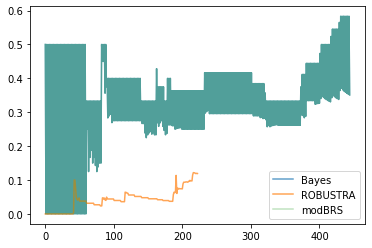

In [272]:
exp1.plot(101,204)

222
444
444


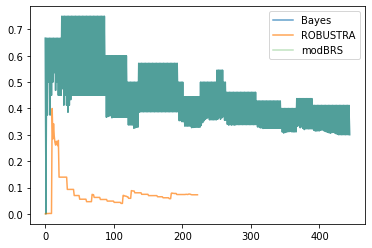

In [273]:
exp1.plot(101,202)

In [266]:
exp1.total_transactions_for_all

222

In [267]:
exp1.consumers[101].total_interactions

16